In this notebook we implement the quantum phase estimation algorithm in qiskit. We are given a wavefunction $\ket{\psi}$ which is an eigenvector of a unitary $U$ with unknown eigenvalue $e^{i \theta}$. To estimate this eigenvalue we introduce $N$ ancilla qubit which couple to $\ket{\psi}$ with control $U^n$ gates with $n$ a power of $2$ between $0$ and $N-1$. Phase kick back paired with an inverse quantum Fourier transform allows for an estimate of $\theta$. 

In [13]:
from numpy import pi

from qiskit import QuantumCircuit, transpile

# For older versions of qiskit import Aer

# For newer versions of qiskit must import qiskit_aer

from qiskit_aer import AerSimulator


# If we instead wanted to make a noisy simulation we could use the following

#from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit.visualization import plot_histogram

# Introduce QFT and QFT_dag functions for use in the quantum phase estimation algorithm

def qft(qc, n):
    for target_qubit in range(n):
        qc.h(n- 1 - target_qubit)
    for control_qubit in range(n-1-target_qubit):
        qc.cp(pi/2**(target_qubit-control_qubit), control_qubit, n-1- target_qubit)
    qc.barrier()

    for i in range(n//2):
        qc.swap(i, n-1-i)

    return qc

# Append to a quantum circuit the inverse QFT

def qft_dag(qc, n):
    # Create a QFT circuit of 'n' qubits
    qft_circ = qft(QuantumCircuit(n), n)

    # Take the inverse of the circuit
    qft_inv_circ = qft_circ.inverse()

    # Add the inverse QFT to the first 'n' qubits of the quantum circuit 'qc'
    qc.append(qft_inv_circ, qc.qubits[:n])

    return qc

def qft_dagger(qc, n):

    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-pi/float(2**(j-m)), m, j)
        qc.h(j)


In [14]:
# Implement Quantum Phase Estimation circuit with N ancilla, the last qubit will be the eigenstate of the unitary operator U

def qpe(qc, N, phase):
    # Apply Hadamard gates to the N ancilla qubits
    for qubit in range(N):
        qc.h(qubit)

    # Apply the controlled unitary operators. Assume the unitary U is a rotation gate for simplicity.
    for counting_qubit in range(N):
        qc.cp(phase * (2**(counting_qubit)), counting_qubit, N)

    # Apply the inverse QFT
    qc = qft_dagger(qc, N)

    return qc


Total counts are: {'001': 1000}


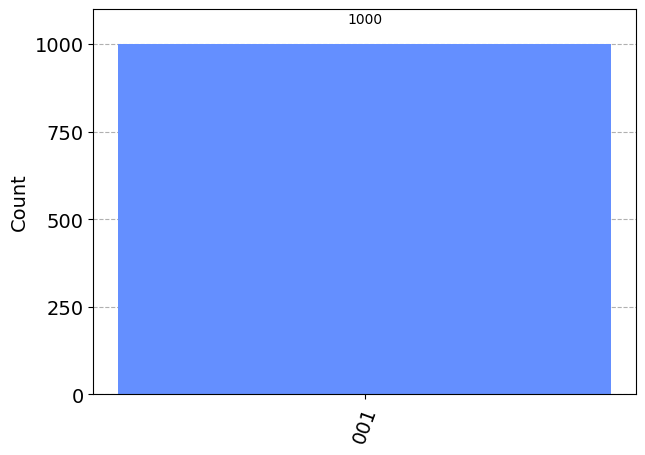

In [15]:
# Create a quantum circuit with N ancilla qubits and 1 qubit for the eigenstate of the unitary operator U

N = 3

qc = QuantumCircuit(N+1, N)

# Prepare the eigenstate of the unitary operator U 

qc.x(N)

# Apply the Quantum Phase Estimation circuit with fixed phase

phase = pi/4

qpe(qc,N,phase)

for i in range(N):
    qc.measure(i,i)

qc.draw()

simulator = AerSimulator()

# Execute the circuit on the simulator
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(compiled_circuit)
print("\nTotal counts are:",counts)

# Plot a histogram
plot_histogram(counts)
